In [5]:
global C_oxygen, k_c, h_c, s_v, alpha_b, alpha_t, M_max, C_50, phi_c, phi_t, C_t, C_c
# Oxygen        
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 5.2*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 18*10**(-3) # 
q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood
C_oxy = [0.018000000000000002,
0.01801412609563047,
0.018021128099442466,
0.018028170955578546,
0.018002825219126096,
0.018004235386929017,
0.0180056471838226,
0.018002208842707274,
0.018003311771512924,
0.01800441569594822,
0.018006622549487716,
0.018007724485053587,
0.018008827415352487,
0.018012563666585386,
0.018014427514077287,
0.018016294216555085,
0.018020228365461462,
0.018022190689342577,
0.0180241561836711]

def dC_dt(C_t):
    global k_c, s_v, phi_c, h_c, phi_t, alpha_b, alpha_t, M_max, C_50, C_c
    # diffusion
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    # consumption
    consumption = (M_max * C_t) / (C_t + C_50)
    
    return diffusion + consumption


C_oxy = np.array(C_oxy)  # 转换为 NumPy 数组
dcdt = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_oxy / alpha_t)) + (M_max * C_oxy) / (C_oxy + C_50)
dcdt
print(dcdt)


[0.02825219 0.0281708  0.02813045 0.02808988 0.02823591 0.02822779
 0.02821965 0.02823946 0.02823311 0.02822675 0.02821403 0.02820768
 0.02820133 0.0281798  0.02816906 0.02815831 0.02813564 0.02812433
 0.02811301]


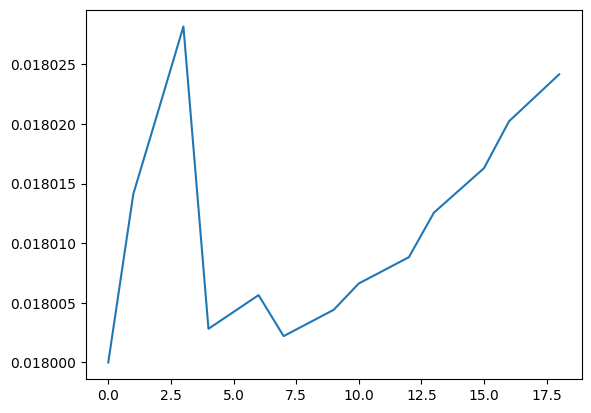

In [7]:
import matplotlib.pyplot as plt

plt.plot(C_oxy, label='Oxygen')

In [2]:
        # if oxy_switch == 1:
        #     # Calculate current dcdt
        #     dcdt = dC_dt(C_oxy)
            
        #     # Define oxygen reset interval (e.g. 1 second)
        #     oxy_reset_interval = 1.0  
            
        #     # Check if reset interval has elapsed
        #     if t - last_oxy_reset >= oxy_reset_interval:
        #         # Reset to initial values
        #         C_c = 5.2*10**(-5)  # m3 O2 / mmHg*m3 blood
        #         C_t = 18*10**(-3)  # m3 O2 / mmHg*m3 blood
        #         last_oxy_reset = t  # Update last reset time
        #     else:
        #         # Normal update during interval
        #         C_c -= dcdt
        #         C_t += dcdt

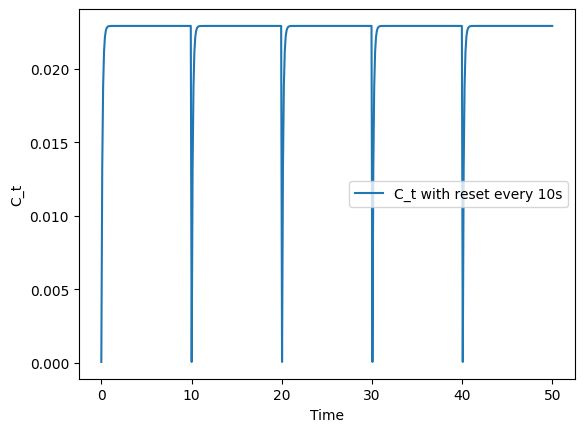

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 5.2*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 18*10**(-3) # 
q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood

# 初始条件
C_t0 = 5.2*10**(-5)
C_50 = C_t0 / 2  # 根据你的假设
dt = 0.1  # 时间步长
T = 50  # 总模拟时间
steps = int(T / dt)  # 计算步数

# 存储时间序列
C_t_values = np.zeros(steps)
C_t_values[0] = C_t0
time = np.linspace(0, T, steps)

# 定义 dC_t/dt
def dC_dt(C_t):
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    consumption = (M_max * C_t) / (C_t + C_50)
    return diffusion + consumption

# 欧拉法迭代
for i in range(1, steps):
    if i * dt % 10 == 0:  # 每 10s 重置 C_t
        C_t_values[i] = C_t0
    else:
        C_t_values[i] = C_t_values[i-1] + dt * dC_dt(C_t_values[i-1])

# 绘制结果
plt.plot(time, C_t_values, label="C_t with reset every 10s")
plt.xlabel("Time")
plt.ylabel("C_t")
plt.legend()
plt.show()


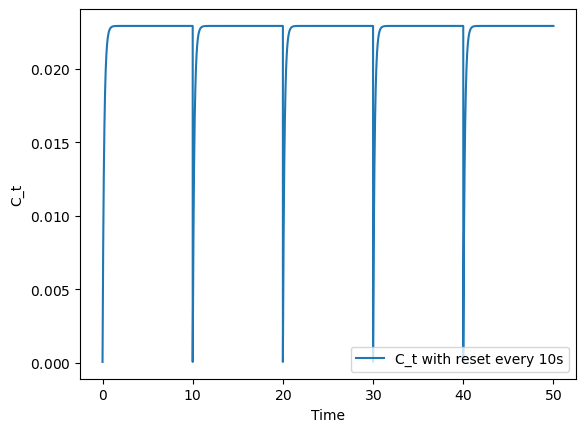

In [ ]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 定义微分方程
def dC_dt(C_t, t):
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    consumption = (M_max * C_t) / (C_t + C_50)
    return diffusion + consumption

# 设置时间区间
T = 50
dt = 0.01
time_segments = np.arange(0, T+dt, 10)  # 每 10s 一个区间
time_all = []
C_t_all = []

C_t_current = C_t0  # 初始值

for i in range(len(time_segments) - 1):
    t_range = np.linspace(time_segments[i], time_segments[i+1], int(10/dt))
    sol = odeint(dC_dt, C_t_current, t_range)  # 计算微分方程
    time_all.extend(t_range)
    C_t_all.extend(sol.flatten())
    C_t_current = C_t0  # 每 10s 重置

# 绘制结果
plt.plot(time_all, C_t_all, label="C_t with reset every 10s")

# 获取当前坐标轴
ax = plt.gca()

# 设置 x 轴为科学计数法
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))  # 设置科学计数法范围

# 设置 y 轴为科学计数法
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))

plt.xlabel("Time")
plt.ylabel("C_t")
plt.legend()
plt.show()



In [3]:
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 4.5*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 5*10**(-4) # 

q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood

C_O2Hb = 64 # umol/L
C_pa = C_c
V_pa = 10 # cm3
Q_pa = 12.5 # cm3/s

C_oxy = (Q_pa*10**(-6)*C_O2Hb*22.4*10**(-6) + C_pa*V_pa)/V_pa
C_oxy2 = (Q_pa*C_O2Hb*10**(-3) + C_pa*V_pa)/V_pa*10**(-6)*0.0224 # m3/m3
C_oxy3 = (Q_pa*10**(-6)*C_O2Hb*22.4+ C_pa*V_pa)/(V_pa) # m3/m3

In [4]:
print(C_oxy, C_oxy2)
print(C_oxy3)

0.000500001792 1.8032e-09
0.0022919999999999998


In [4]:
import numpy as np

def calculate_PO2(HB_O2):
    # 已知参数
    L = 1.251
    k = 0.0676  # [1/mmHg]
    m = 17.71   # [mmHg]
    b = -0.274

    # 计算 PO2
    PO2 = m - (1 / k) * np.log((L / (HB_O2 - b)) - 1)
    return PO2

# 示例：输入 HB_O2 值
HB_O2_value = 0.97  # 示例值，可以根据需要更改
PO2_value = calculate_PO2(HB_O2_value)

print(f"当 HB_O2 = {HB_O2_value} 时，计算得到的 PO2 = {PO2_value:.4f} mmHg")


当 HB_O2 = 0.97 时，计算得到的 PO2 = 94.3398 mmHg


In [2]:
import numpy as np

Hb_baseline = 150.0 # g/L
L = 1.251   # 氧-血红蛋白解离曲线参数
k = 0.0676  # 1/mmHg
m = 17.71   # mmHg
b = -0.274  # 偏移量
O2_capacity = 1.34  # mL O2/g Hb, 血红蛋白氧容量
alpha_p = 0.0031  # 氧气在血浆中的溶解系数

def patial_pressure(SaO2):
    """从SaO2计算PO2"""
    return m + np.log(L / (SaO2 - b) - 1) / (-k)


oo = patial_pressure(0.70)
o2 = 0.0031*oo
print(oo)
newo2 = o2*1e-2 # ml O2/ml blood
Cc = newo2/22.4 * 1e6 # umol/L

print(f'当 HB_O2 = 0.97 时，计算得到的 o2 = {o2:.4f} mL/dL')
print(f'当 HB_O2 = 0.97 时，计算得到的 newo2 = {newo2:.4f} m3/m3')
print(f"当 HB_O2 = 0.97 时，计算得到的 Cc = {Cc:.4f} umol/L")



36.31049996235498
当 HB_O2 = 0.97 时，计算得到的 o2 = 0.1126 mL/dL
当 HB_O2 = 0.97 时，计算得到的 newo2 = 0.0011 m3/m3
当 HB_O2 = 0.97 时，计算得到的 Cc = 50.2511 umol/L


C:\Users\sunny\AppData\Local\Temp\ipykernel_29860\4028507831.py:13: RuntimeWarning: invalid value encountered in log
  return m + np.log(L / (SaO2 - b) - 1) / (-k)


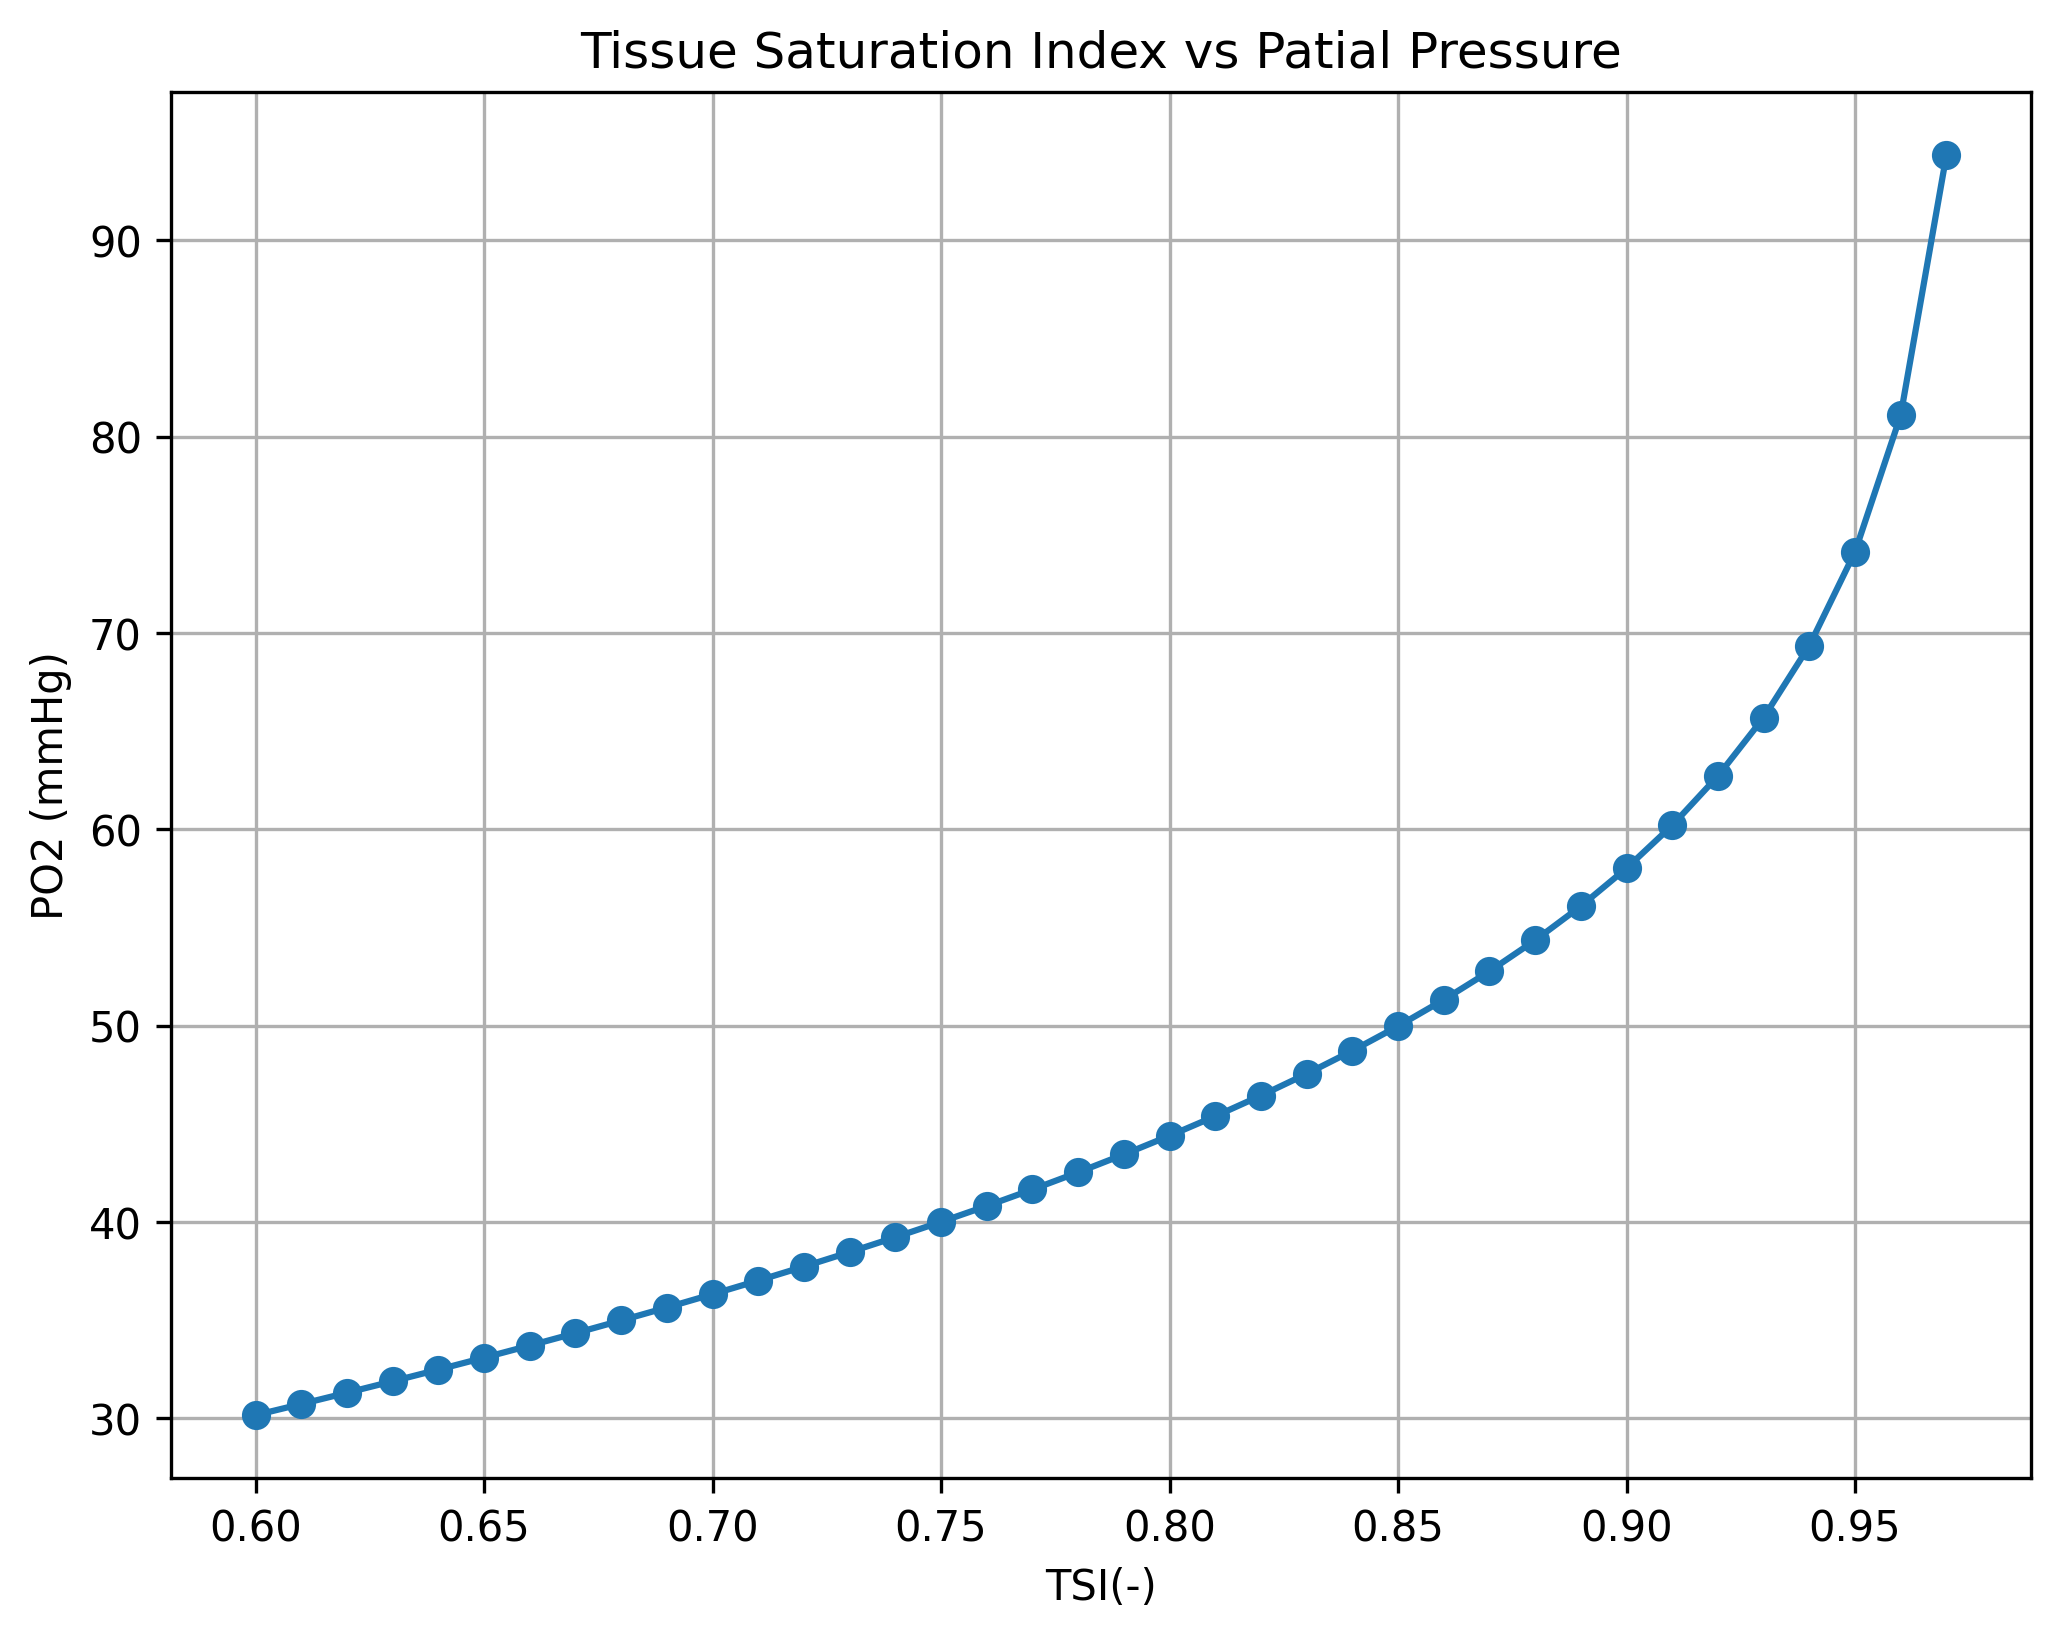

In [19]:
import matplotlib.pyplot as plt

TSI_list = np.linspace(0.6, 1, 41)
result = []
for i in TSI_list:
    pressure = patial_pressure(i)
    result.append(pressure)

plt.figure(figsize=(8, 6),dpi=300)
plt.plot(TSI_list, result, '-o',label='PO2')
plt.xlabel("TSI(-)")
plt.ylabel("PO2 (mmHg)")
plt.title("Tissue Saturation Index vs Patial Pressure")
plt.grid()
plt.show()


In [13]:
import numpy as np
from scipy.optimize import fsolve

def po2_equation(PO2, SaO2):
    return ((1 / (PO2**3 + 150 * PO2) * 23400 + 1)**-1 * 100) - SaO2

def calculate_PO2(SaO2):
    # 使用 fsolve 进行数值求解，初始猜测设为 100
    PO2_initial_guess = 100
    PO2_solution = fsolve(po2_equation, PO2_initial_guess, args=(SaO2,))
    return PO2_solution[0]

# 测试
SaO2_value = 97  # 假设 SaO2 为 90%
PO2_result = calculate_PO2(SaO2_value)
print(f"对应的 PO2 值为: {PO2_result:.2f}")


对应的 PO2 值为: 90.57


In [29]:
import numpy as np

Hb_baseline = 150.0 # g/L
L = 1.251   # 氧-血红蛋白解离曲线参数
k = 0.0676  # 1/mmHg
m = 17.71   # mmHg
b = -0.274  # 偏移量
O2_capacity = 1.34  # mL O2/g Hb, 血红蛋白氧容量
alpha_p = 0.0031  # 氧气在血浆中的溶解系数

def saturation1(PO2):
    """从PO2计算SaO2"""
    return (L / (1 + np.exp(-k*(PO2 - m)))) + b


def saturation2(PO2):
    """从PO2计算SaO2"""
    return ((((PO2)**3 + 150*PO2)**(-1)*23400) + 1)**(-1)*100



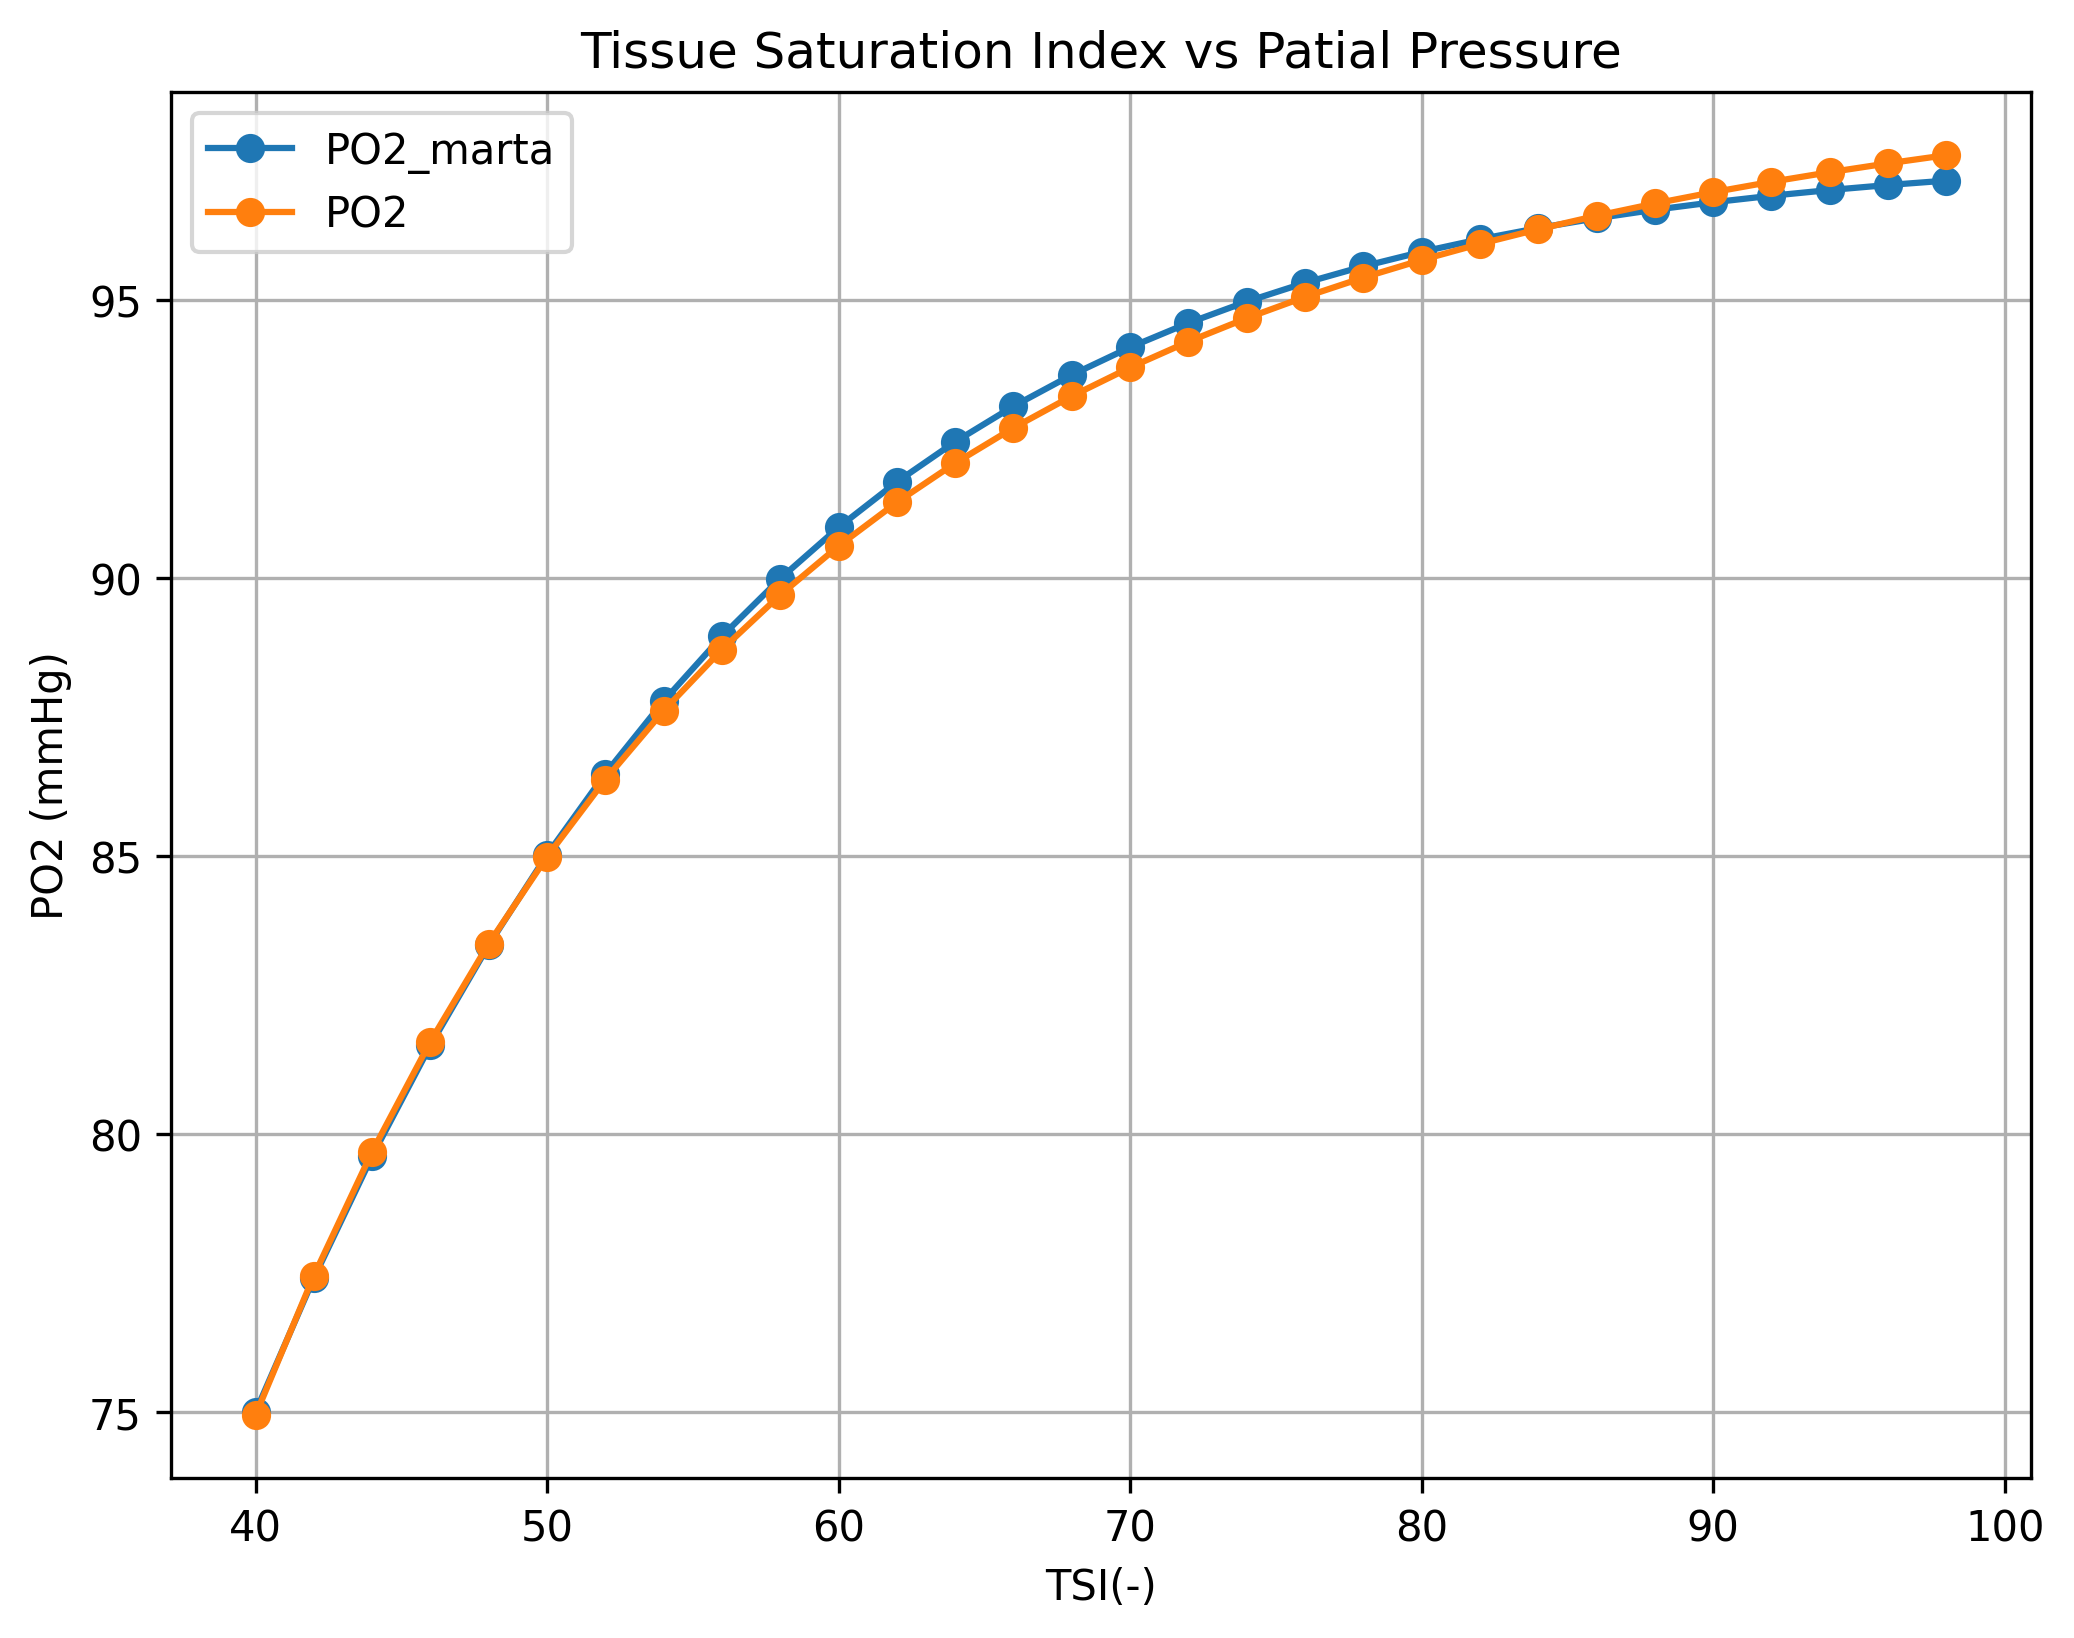

In [30]:
import matplotlib.pyplot as plt

PO_list = np.linspace(40, 98, 30)
result1 = []
result2 = []
for i in PO_list:
    pressure1 = saturation1(i)*100
    pressure = saturation2(i)
    result1.append(pressure1)
    result2.append(pressure)

plt.figure(figsize=(8, 6),dpi=300)
plt.plot(PO_list, result1, '-o',label='PO2_marta')
plt.plot(PO_list, result2, '-o',label='PO2')
plt.xlabel("TSI(-)")
plt.ylabel("PO2 (mmHg)")
plt.title("Tissue Saturation Index vs Patial Pressure")
plt.legend()
plt.grid()
plt.show()